# Modern Portfolio Theory

Given a number of stocks, we simulate a number of portfolios, compute the efficient frontier, maximum Sharpe portfolio, minimum variance portfolio and capital market line.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
from dateutil.relativedelta import relativedelta

import yfinance as yf
import pandas_ta as ta
import mplfinance as mpf
import pandas_datareader.data as web
import statsmodels.api as sm
%run '../functions.ipynb'

The mathematical formulas involved in the mean-variance portfolio analysis are:

$P=\sum_i w_i R_i=w\cdot R$

$E(P)=\sum_i w_i E(R_i) = w\cdot E(R)$

$V(P)=\sum_i w_i^2 V(R_i) + \sum_{i\neq j}w_{i}w_{j}Cov(R_i,R_j)= w^T \Sigma\,w$

In [2]:
def weights_to_pf_2(some_stocks, weights):
    for i in range(100):
        daily_ret=log_ret(some_stocks).dropna()
        pf_daily_ret=daily_ret*weights
        pf_sum_ret=pf_daily_ret.sum(axis=1)
        pf_annual_ret=252* (pf_sum_ret.mean())
        pf_annual_vol=np.sqrt(252* (pf_sum_ret.var()))

    return(pf_annual_ret,pf_annual_vol)

In [524]:
raw=pd.read_csv('../../Pythonforfinance/tr_eikon_eod_data.csv')
data=pd.DataFrame(raw).set_index(['Date']).dropna()
idx=['SPY', 'GLD','AAPL.O','MSFT.O']
data2=data[idx]

In [670]:
def gen_weights(num, short=True):
    weights=np.random.random(num)
    #if short==True:
    #    weights=weights-0.5
    #else:
    #    weights=weights
    weights=weights/weights.sum()
    return weights





def weights_to_pf(some_stocks, weights):
    weights=np.array(weights)/np.array(weights).sum()
    daily_log_returns=log_ret(some_stocks)
    ER=252*(daily_log_returns.mean())
    CovR=252*(daily_log_returns.cov())
    #ER=np.exp(ER)-1
    #CovR=np.exp(CovR)

    EP=np.dot(weights,ER)
    VP=np.dot(weights, np.dot(CovR, weights))
    sigmaP=np.sqrt(VP)

    return (EP, sigmaP)




def gen_pfs(data, rf, num_pfs):
    sharpes=[]
    exps=[]
    vols=[]
    weights_list=[]
    number_of_assets=len(data.columns)
    for i in range(num_pfs):
        weights=gen_weights(number_of_assets)
        pf=weights_to_pf(data, weights)
        sharpes.append((pf[0]-rf)/pf[1])
        exps.append(pf[0])
        vols.append(pf[1])
        weights_list.append(weights)
    results={}
    results['sharpes']=sharpes
    results['exps']=exps
    results['vols']=vols
    results['weights']=weights_list
    return results

In [666]:
#MAIN PROGRAM: SIMULATION OF PORTFOLIOS

def simulation(data, rf, num_pfs):

    #add a riskfree asset to the data with annual return 'rf'
    #riskfree=pd.Series((1+np.log(rf+1)/252)*np.ones(len(data)),index=data.index,dtype=float).cumprod()
    #data['riskfree']=riskfree
    
### Generate the portfolios
    number_of_assets=len(data.columns)
    portfolios=gen_pfs(data,rf,num_pfs)
        
#########################################################
    import scipy.optimize as sco

### Definition of objective functions to be optimized
  
    def sharpe(weights):
        e,sigma=weights_to_pf(data,weights)
        return (e-rf)/sigma

    def neg_sharpe(weights):
        return -sharpe(weights)
    
    def expected_vol(weights):
        return weights_to_pf(data,weights)[1]

    def expected_ret(weights):
        return weights_to_pf(data,weights)[0]


### Maximize sharpe ratio

    sum_to_one={'type':'eq', 'fun':lambda x: np.sum(x)-1}
    bounds=tuple((0,1) for x in range(number_of_assets))
    init_weights=np.ones(number_of_assets)*(1/number_of_assets)

    opt_sharpe_pf=sco.minimize(neg_sharpe, constraints=sum_to_one, bounds=bounds, x0=init_weights)
    
    opt_sharpe_weights=opt_sharpe_pf['x']
    opt_sharpe_exp=expected_ret(opt_sharpe_weights)
    opt_sharpe_vol=expected_vol(opt_sharpe_weights)
    opt_sharpe_sharpe=sharpe(opt_sharpe_weights)

### Minimize volatility
    
    opt_vol_pf=sco.minimize(expected_vol, constraints=sum_to_one, bounds=bounds, x0=init_weights)

    opt_vol_weights=opt_vol_pf['x']
    opt_vol_exp=expected_ret(opt_vol_weights)
    opt_vol_vol=expected_vol(opt_vol_weights)
    opt_vol_sharpe=sharpe(opt_vol_weights)
    
### Minimize volatility for a given return    
    

    ret_levels=np.linspace(opt_vol_exp,opt_sharpe_exp,20) 
    
    
    volatilities=[]
    for ret in ret_levels:
        fixed_return={'type':'eq', 'fun':lambda x: expected_ret(x)-ret}
        opt=sco.minimize(expected_vol, constraints=[sum_to_one,fixed_return], bounds=bounds, x0=init_weights)
        volatilities.append(opt['fun'])


########################################################################     
### RESULTS ############################################################                
        
    results={}
    results['portfolios']=portfolios
    
    results['max_sharpe_pf']={'weights':opt_sharpe_weights,\
                              'sharpe': opt_sharpe_sharpe,\
                              'exp': opt_sharpe_exp,\
                              'vol': opt_sharpe_vol}
                              
    results['min_vol_pf']={'weights':opt_vol_weights,\
                              'sharpe': opt_vol_sharpe,\
                              'exp': opt_vol_exp,\
                              'vol': opt_vol_vol}
    
    #results['frontier']={'exps': ret_levels[np.argmin(volatilities):], 'vols':volatilities[np.argmin(volatilities):]}
    results['frontier']={'exps': ret_levels, 'vols':volatilities}

    results['rf']=rf
    
    
    print('Max-sharpe portfolio:', opt_sharpe_weights)
    print('Max-sharpe returns:', opt_sharpe_exp)
    print('Max-sharpe volatility:', opt_sharpe_vol)
    print('Max-sharpe sharpe:', opt_sharpe_sharpe)
    print('--------------------------------------------')
    print('Min-volatility portfolio:', opt_vol_weights)
    print('Min-volatility returns:', opt_vol_exp)
    print('Min-volatility volatility:', opt_vol_vol)
    print('Min-volatility sharpe:', opt_vol_sharpe)


    return results

    


In [667]:
def plot_simulation(sim):
    
    
    effvols=np.array(sim['frontier']['vols'])
    effrets=np.array(sim['frontier']['exps'])

    sort_idx=np.argsort(effvols)

    effvols=effvols[sort_idx]
    effrets=effrets[sort_idx]

    xmargin=0.5*abs(effvols[-1]-effvols[0])
    ymargin=0.5*abs(effrets[-1]-effrets[0])
    
    ret_lower_bound=min(sim['portfolios']['exps'])
    ret_upper_bound=max(sim['portfolios']['exps'])
    vol_lower_bound=min(sim['portfolios']['vols'])
    vol_upper_bound=max(sim['portfolios']['vols'])


    rf=sim['rf']

    plt.figure(figsize=(8,4))
    plt.xlim(vol_lower_bound-xmargin,effvols[-1]+xmargin)
    plt.ylim(ret_lower_bound-ymargin,effrets[-1]+ymargin)
    
    
    plt.margins(x=0)
    plt.margins(y=0)
    plt.scatter(sim['portfolios']['vols'],sim['portfolios']['exps'],s=10, c=sim['portfolios']['sharpes'], cmap='coolwarm',alpha=0.5)
    plt.colorbar(label='Sharpe ratio')


    plt.scatter(sim['max_sharpe_pf']['vol'],sim['max_sharpe_pf']['exp'], s=100, color='magenta', label='max Sharpe pf')
    plt.scatter(sim['min_vol_pf']['vol'],sim['min_vol_pf']['exp'], s=100, color='k', label='min volatility pf')



    import scipy.interpolate as sci
    spl=sci.splrep(effvols,effrets, k=3) #cubic spline interpolation

    def f(x):
        return sci.splev(x, spl, der=0)

    def df(x):
        return sci.splev(x, spl, der=1) #first derivative


    #plot interpolated efficient frontier
    lin=np.linspace(effvols[0],effvols[-1],100)
    plt.plot(lin,f(lin), lw=2.5, color='blue',label='efficient frontier')


    def equation(x):
        eq=f(x)-rf-df(x)*x
        return eq
    opt=sco.fsolve(equation, sim['max_sharpe_pf']['vol']) #initial guess

    
    tang_x=opt[0]
    tang_y=f([tang_x])[0]
    cml_slope=df([tang_x])[0]

    #capital market line:
    xvals=np.linspace(vol_lower_bound-xmargin,effvols[-1]+xmargin)
    plt.plot(xvals, rf+cml_slope*xvals,'green', lw=2,label='capital market line')
    plt.legend()

The Capital Market Line: $E(R)=R_f+\frac{E(R_M)-R_f}{\sigma_M}\sigma$.

The tangency point of the CML with the efficient frontier is the market portfolio. This is the maximum-Sharpe portfolio when we only consider risky assets, whereas, when we add the risk-free asset, all portfolios on the CML are feasible and have the same Sharpe ratio).

In [671]:
sim=simulation(data2,0,3000)

Max-sharpe portfolio: [0.25454109 0.04228125 0.51191352 0.19126414]
Max-sharpe returns: 0.1614313639552647
Max-sharpe volatility: 0.1798342747657251
Max-sharpe sharpe: 0.8976673894093082
--------------------------------------------
Min-volatility portfolio: [0.54326308 0.45567522 0.         0.0010617 ]
Min-volatility returns: 0.060227522349279757
Min-volatility volatility: 0.10942155263406483
Min-volatility sharpe: 0.5504173620227892


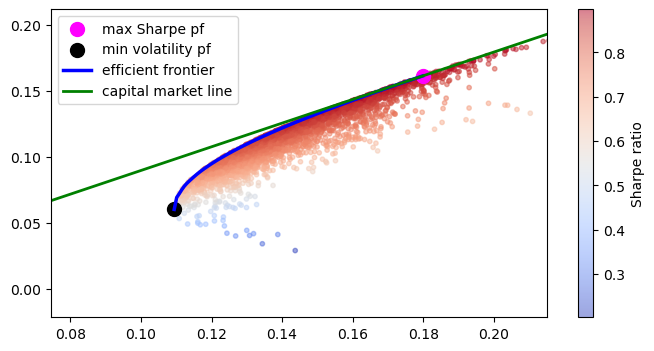

In [672]:
plot_simulation(sim)

Let's try it with some other data:

In [467]:
data=yf.download("SPY AAPL MSFT TSLA GOOG", period="1y", interval='1d')

[*********************100%%**********************]  5 of 5 completed


In [468]:
spy=data.Close['SPY']
stocks=data.Close.drop('SPY',axis=1)


In [662]:
sim=simulation(stocks.iloc[:,1:4], 0, 3000)

Max-sharpe portfolio: [1.31317611e-01 8.68682389e-01 5.75859055e-16]
Max-sharpe returns: 0.4363555220306192
Max-sharpe volatility: 0.21676380082638597
Max-sharpe sharpe: 2.0130460914925195
--------------------------------------------
Min-volatility portfolio: [0.28475293 0.66711195 0.04813512]
Min-volatility returns: 0.3938105586611838
Min-volatility volatility: 0.2106576346074571
Min-volatility sharpe: 1.8694340672485803


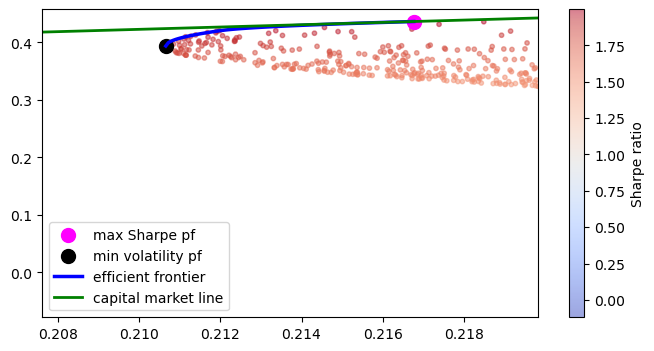

In [664]:
plot_simulation(sim)